In [1]:
%load_ext zipline

[2018-10-22 12:12:04.628593] INFO: zipline.finance.metrics.tracker: Simulated 755 trading days
first open: 2015-01-02 14:31:00+00:00
last close: 2017-12-29 21:00:00+00:00


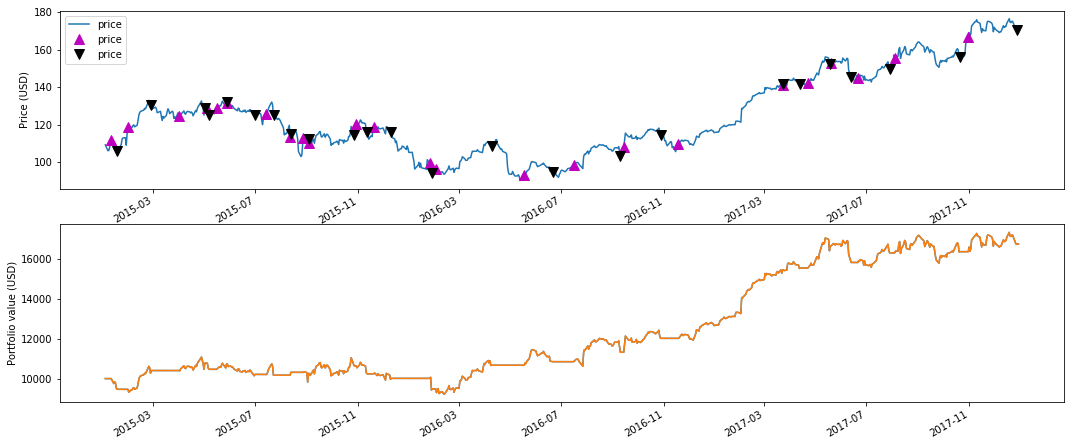

,ATR,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,downside_signal,ending_cash,...,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,upside_signal
2015-01-02 21:00:00+00:00,2.540950,NaN,0.000000,NaN,-0.000535,NaN,NaN,0.00,-1.490950,10000.000000,...,0.0,0,NaN,10000.000000,0.00,0.00,1,[],0.0,-3.590950
2015-01-05 21:00:00+00:00,2.653235,0.000000,0.000000,0.000000,-0.018585,0.196720,0.000000,0.00,0.426765,10000.000000,...,0.0,0,NaN,10000.000000,0.00,0.00,2,[],0.0,-5.733235
2015-01-06 21:00:00+00:00,2.693230,0.000000,0.000000,0.000000,-0.027829,0.139106,0.000000,0.00,-2.703230,10000.000000,...,0.0,0,NaN,10000.000000,0.00,0.00,3,[],0.0,-2.683230
2015-01-07 21:00:00+00:00,2.652337,0.000000,0.000000,0.000000,-0.015715,0.206973,0.000000,0.00,-4.142337,10000.000000,...,0.0,0,NaN,10000.000000,0.00,0.00,4,[],0.0,-1.162337
2015-01-08 21:00:00+00:00,2.795032,0.000000,0.000000,0.000000,0.001752,0.236042,0.000000,0.00,-6.935032,10000.000000,...,0.0,0,NaN,10000.000000,0.00,0.00,5,[],0.0,1.344968
2015-01-09 21:00:00+00:00,2.851878,0.000648,-0.000100,-0.004018,-0.006276,0.218112,0.000746,-9969.89,-2.971878,30.110000,...,0.0,0,-6.480741,10000.000000,0.00,0.00,6,"[{u'commission': None, u'amount': 89, u'sid': ...",0.0,-2.731878
2015-01-12 21:00:00+00:00,2.967296,0.147300,-0.024664,-0.815512,-0.014060,0.203322,0.147448,0.00,-0.207296,30.110000,...,0.0,0,-6.024374,30.110000,9968.89,9968.89,7,[],0.0,-5.727296
2015-01-13 21:00:00+00:00,2.926110,0.153041,-0.016031,-0.426659,-0.016834,0.188302,0.137874,0.00,-3.896110,30.110000,...,0.0,0,-3.613120,30.110000,9723.25,9723.25,8,[],0.0,-1.956110
2015-01-14 21:00:00+00:00,2.858448,0.143481,-0.019769,-0.459475,-0.022769,0.177394,0.142382,0.00,-2.438448,30.110000,...,0.0,0,-4.175118,30.110000,9809.58,9809.58,9,[],0.0,-3.278448
2015-01-15 21:00:00+00:00,2.924250,0.184107,-0.046291,-0.952313,-0.031722,0.170558,0.280454,0.00,0.055750,30.110000,...,0.0,0,-6.376399,30.110000,9772.20,9772.20,10,[],0.0,-5.904250


In [6]:
%%zipline --start 2015-1-1 --end 2018-1-1  --capital-base 10000 -o ../data/strategy5.pickle

# This strategy was taken from http://www.investopedia.com/articles/trading/08/atr.asp

# The idea is to use ATR to identify breakouts, if the price goes higher than
# the previous close + ATR, a price breakout has occurred. The position is closed when
# the price goes 1 ATR below the previous close. 

# This algorithm uses ATR as a momentum strategy, but the same signal can be used for 
# a reversion strategy, since ATR doesn't indicate the price direction.


from zipline.api import (
    order, 
    record, 
    symbol, 
    set_long_only, 
    order_target_percent, 
    schedule_function,
    date_rules,
    time_rules)

from zipline.finance import commission, slippage
# Import exponential moving average from talib wrapper

import numpy as np
import pandas as pd
import talib
from talib import EMA

# Setup our variables
def initialize(context):
    # SPY
    context.spy = symbol('AAPL')
    
    # Algorithm will only take long positions.
    # It will stop if encounters a short position. 
    set_long_only()
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())
    
    schedule_function(rebalance, date_rules.every_day(), time_rules.market_open())

    
     
# Rebalance daily.
def rebalance(context, data):
    
    # Track our position
    current_position = context.portfolio.positions[context.spy].amount
    record(position_size=current_position)
    
    
    # Load historical data for the stocks
    hist = data.history(context.spy, ['high', 'low', 'close'], 30, '1d')
    
    # Calculate the ATR for the stock
    atr = talib.ATR(hist['high'],
                    hist['low'],
                    hist['close'],
                    timeperiod=14)[-1]
    
    price = data.current(context.spy, 'price')
    
    # Use the close price from yesterday because we trade at market open
    prev_close = hist['close'][-2]
    
    # An upside breakout occurs when the price goes 1 ATR above the previous close
    upside_signal = price - (prev_close + atr)
    
    # A downside breakout occurs when the previous close is 1 ATR above the price
    downside_signal = prev_close - (price + atr)
    
    # Enter position when an upside breakout occurs. Invest our entire portfolio to go long.
    if upside_signal > 0 and current_position <= 0 and data.can_trade(context.spy):
        order_target_percent(context.spy, 1)
    
    # Exit position if a downside breakout occurs
    elif downside_signal > 0 and current_position >= 0 and data.can_trade(context.spy):
        order_target_percent(context.spy, 0)
        
    
    record(upside_signal=upside_signal,
           downside_signal=downside_signal,
           ATR=atr,
           price=price)
    


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context, perf):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(212)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(211)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if 'price' in perf and 'ATR' in perf:
        
        perf_trans = perf.ix[[t != [] for t in perf.transactions]]
        buys = perf_trans.ix[
        [t[0]['amount'] > 0 for t in perf_trans.transactions]]
        sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
        
        perf['price'].plot(ax=ax2)
        ax2.plot(buys.index, perf['price'].ix[buys.index],
             '^', markersize=10, color='m')
        ax2.plot(sells.index, perf['price'].ix[sells.index],
             'v', markersize=10, color='k')
        
        plt.legend(loc=0)
        plt.gcf().set_size_inches(18, 8)
        
        perf.portfolio_value.plot(ax=ax1)
    
    plt.gcf().set_size_inches(18, 8)
    plt.show() 

In [ ]:
import pandas as pd
perf = pd.read_pickle('../data/strategy5.pickle')
perf.columns
perf[['benchmark_period_return','algorithm_period_return']]